In [2]:
import pandas as pd
import numpy as np
# import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn import preprocessing, decomposition

seed = 42
FILENAME = "train_dataset.csv"

In [2]:
# 1. read_csv
# 2. dropna
# 3. drop label
# 4. replace src_bytes
# 5. casting 
# 6. encoding (cat/num)
# 7. extract y 
# 8. drop type
# 9. label encoding on y

import

In [3]:
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

(617002, 27)


splitting

In [4]:
indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]

preprocess

In [5]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

pca = decomposition.PCA(n_components='mle', svd_solver='full')
pca.fit(X_train)

X = pca.transform(X)

In [6]:
print(pca.explained_variance_ratio_)

[1.44900607e-01 1.33969802e-01 1.33675083e-01 4.92563102e-02
 4.70841450e-02 4.61255229e-02 4.54983184e-02 4.23647696e-02
 3.90549396e-02 3.04763781e-02 2.33517088e-02 2.29889283e-02
 2.21947914e-02 2.17003153e-02 2.08727979e-02 2.00212553e-02
 1.97292747e-02 1.88016761e-02 1.76938953e-02 1.65682323e-02
 1.54616886e-02 1.51850213e-02 9.87827754e-03 7.51437108e-03
 6.96394655e-03 5.98062813e-03 5.02077679e-03 4.85400224e-03
 2.14769257e-03 2.05417698e-03 1.90607313e-03 1.43796611e-03
 1.20337627e-03 1.14801797e-03 9.00030610e-04 7.01092490e-04
 3.94912281e-04 3.89787902e-04 3.12938584e-04 1.14936749e-04
 1.01535087e-04]


In [4]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pickle

---

# RandomForest

In [8]:
# RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy']
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1; 3/6] START criterion=gini, n_estimators=200............................
[CV 1/1; 1/6] START criterion=gini, n_estimators=50.............................
[CV 1/1; 5/6] START criterion=entropy, n_estimators=100.........................
[CV 1/1; 4/6] START criterion=entropy, n_estimators=50..........................
[CV 1/1; 2/6] START criterion=gini, n_estimators=100............................
[CV 1/1; 6/6] START criterion=entropy, n_estimators=200.........................
[CV 1/1; 1/6] END criterion=gini, n_estimators=50; balanced_accuracy: (test=0.998) f1_weighted: (test=0.999) total time= 3.5min
[CV 1/1; 4/6] END criterion=entropy, n_estimators=50; balanced_accuracy: (test=0.998) f1_weighted: (test=1.000) total time= 3.7min
[CV 1/1; 2/6] END criterion=gini, n_estimators=100; balanced_accuracy: (test=0.997) f1_weighted: (test=1.000) total time= 6.6min
[CV 1/1; 5/6] END criterion=entropy, n_estimators=100; balanced_acc

---

---

In [9]:
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

(617002, 27)


In [10]:
indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]

In [11]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

# pca = decomposition.PCA(n_components='mle', svd_solver='full')
# pca.fit(X_train)

# X = pca.transform(X)

In [12]:
# RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy']
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1; 5/6] START criterion=entropy, n_estimators=100.........................
[CV 1/1; 2/6] START criterion=gini, n_estimators=100............................
[CV 1/1; 3/6] START criterion=gini, n_estimators=200............................
[CV 1/1; 6/6] START criterion=entropy, n_estimators=200.........................
[CV 1/1; 1/6] START criterion=gini, n_estimators=50.............................
[CV 1/1; 4/6] START criterion=entropy, n_estimators=50..........................
[CV 1/1; 4/6] END criterion=entropy, n_estimators=50; balanced_accuracy: (test=0.996) f1_weighted: (test=1.000) total time=  21.8s
[CV 1/1; 1/6] END criterion=gini, n_estimators=50; balanced_accuracy: (test=0.996) f1_weighted: (test=1.000) total time=  22.0s
[CV 1/1; 2/6] END criterion=gini, n_estimators=100; balanced_accuracy: (test=0.997) f1_weighted: (test=1.000) total time=  38.4s
[CV 1/1; 5/6] END criterion=entropy, n_estimators=100; balanced_acc

---

---

In [60]:
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [ ]:
indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

# pca = decomposition.PCA(n_components='mle', svd_solver='full')
# pca.fit(X_train)

# X = pca.transform(X)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda.transform(X)

array([[-5.93179913e+00,  4.00022674e+00, -5.21043260e+00, ...,
        -1.35574797e-01,  3.79912781e+00, -3.88745483e+00],
       [-2.08636621e+00, -3.32270786e-01, -5.36121959e+00, ...,
        -6.07465354e+00, -1.99182280e+00, -3.75603546e-01],
       [-1.00060058e+00, -2.25348998e+00,  4.80439269e-03, ...,
         2.21397783e-01, -7.41315988e-01, -6.65059856e-01],
       ...,
       [ 3.02597595e+00, -2.43900247e+00, -7.13637327e-01, ...,
        -9.33429989e-01, -6.84175604e-01, -1.04748961e+00],
       [ 4.57737595e+00, -1.49195803e+00, -2.10543630e+00, ...,
        -1.85218219e+00,  4.36944697e+00,  1.91918828e+00],
       [ 3.44310869e+00, -2.21994280e+00, -8.77555638e-01, ...,
         1.14568784e+00, -1.37160912e-01, -9.56462870e-01]],
      shape=(617002, 9))

In [15]:
# RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy']
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1; 2/6] START criterion=gini, n_estimators=100............................
[CV 1/1; 1/6] START criterion=gini, n_estimators=50.............................
[CV 1/1; 5/6] START criterion=entropy, n_estimators=100.........................
[CV 1/1; 4/6] START criterion=entropy, n_estimators=50..........................
[CV 1/1; 3/6] START criterion=gini, n_estimators=200............................
[CV 1/1; 6/6] START criterion=entropy, n_estimators=200.........................
[CV 1/1; 4/6] END criterion=entropy, n_estimators=50; balanced_accuracy: (test=0.997) f1_weighted: (test=1.000) total time=  22.6s
[CV 1/1; 1/6] END criterion=gini, n_estimators=50; balanced_accuracy: (test=0.998) f1_weighted: (test=1.000) total time=  23.0s
[CV 1/1; 5/6] END criterion=entropy, n_estimators=100; balanced_accuracy: (test=0.997) f1_weighted: (test=1.000) total time=  39.0s
[CV 1/1; 2/6] END criterion=gini, n_estimators=100; balanced_acc

---

---

---

# SVC

In [16]:
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

(617002, 27)


In [17]:
indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]

In [18]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

pca = decomposition.PCA(n_components='mle', svd_solver='full')
pca.fit(X_train)

X = pca.transform(X)

# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, y_train)
# lda.transform(X)

In [19]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']  
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(SVC(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Fitting 1 folds for each of 40 candidates, totalling 40 fits
[CV 1/1; 8/40] START C=0.1, gamma=auto, kernel=sigmoid..........................
[CV 1/1; 3/40] START C=0.1, gamma=scale, kernel=poly............................
[CV 1/1; 7/40] START C=0.1, gamma=auto, kernel=poly.............................
[CV 1/1; 4/40] START C=0.1, gamma=scale, kernel=sigmoid.........................[CV 1/1; 6/40] START C=0.1, gamma=auto, kernel=rbf..............................

[CV 1/1; 5/40] START C=0.1, gamma=auto, kernel=linear...........................
[CV 1/1; 1/40] START C=0.1, gamma=scale, kernel=linear..........................
[CV 1/1; 2/40] START C=0.1, gamma=scale, kernel=rbf.............................
[CV 1/1; 1/40] END C=0.1, gamma=scale, kernel=linear; balanced_accuracy: (test=0.942) f1_weighted: (test=0.988) total time=28.4min
[CV 1/1; 9/40] START C=1, gamma=scale, kernel=linear............................
[CV 1/1; 5/40] END C=0.1, gamma=auto, kernel=linear; balanced_accuracy: (test=0

KeyboardInterrupt: 

---

In [ ]:
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)


indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]


# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

# pca = decomposition.PCA(n_components='mle', svd_solver='full')
# pca.fit(X_train)

# X = pca.transform(X)

# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, y_train)
# lda.transform(X)


# SVC
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']  
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(SVC(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

---

In [ ]:
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)


indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

# pca = decomposition.PCA(n_components='mle', svd_solver='full')
# pca.fit(X_train)

# X = pca.transform(X)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda.transform(X)


# SVC
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']  
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(SVC(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

---

---

---

# KNN

In [4]:
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)


indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

pca = decomposition.PCA(n_components='mle', svd_solver='full')
pca.fit(X_train)

X = pca.transform(X)

# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, y_train)
# lda.transform(X)


# KNN
param_grid = {
    'n_neighbors': [10,20,50,100,500,775,900,1000],
    'p': [1,2]
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

(617002, 27)
Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV 1/1; 1/16] START n_neighbors=10, p=1........................................
[CV 1/1; 4/16] START n_neighbors=20, p=2........................................
[CV 1/1; 2/16] START n_neighbors=10, p=2........................................
[CV 1/1; 7/16] START n_neighbors=100, p=1.......................................
[CV 1/1; 5/16] START n_neighbors=50, p=1........................................
[CV 1/1; 6/16] START n_neighbors=50, p=2........................................
[CV 1/1; 3/16] START n_neighbors=20, p=1........................................
[CV 1/1; 8/16] START n_neighbors=100, p=2.......................................
[CV 1/1; 2/16] END n_neighbors=10, p=2; balanced_accuracy: (test=0.979) f1_weighted: (test=0.998) total time= 5.7min
[CV 1/1; 9/16] START n_neighbors=500, p=1.......................................
[CV 1/1; 4/16] END n_neighbors=20, p=2; balanced_accuracy: (test=0.970) f1_weigh

In [5]:
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)


indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

# pca = decomposition.PCA(n_components='mle', svd_solver='full')
# pca.fit(X_train)

# X = pca.transform(X)

# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, y_train)
# lda.transform(X)


# KNN
param_grid = {
    'n_neighbors': [10,20,50,100,500,775,900,1000],
    'p': [1,2]
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

(617002, 27)
Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV 1/1; 1/16] START n_neighbors=10, p=1........................................
[CV 1/1; 6/16] START n_neighbors=50, p=2........................................
[CV 1/1; 2/16] START n_neighbors=10, p=2........................................
[CV 1/1; 8/16] START n_neighbors=100, p=2.......................................
[CV 1/1; 7/16] START n_neighbors=100, p=1.......................................
[CV 1/1; 4/16] START n_neighbors=20, p=2........................................
[CV 1/1; 3/16] START n_neighbors=20, p=1........................................
[CV 1/1; 5/16] START n_neighbors=50, p=1........................................
[CV 1/1; 2/16] END n_neighbors=10, p=2; balanced_accuracy: (test=0.979) f1_weighted: (test=0.998) total time= 5.5min
[CV 1/1; 9/16] START n_neighbors=500, p=1.......................................
[CV 1/1; 4/16] END n_neighbors=20, p=2; balanced_accuracy: (test=0.970) f1_weigh

In [6]:
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)


indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

# pca = decomposition.PCA(n_components='mle', svd_solver='full')
# pca.fit(X_train)

# X = pca.transform(X)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda.transform(X)


# KNN
param_grid = {
    'n_neighbors': [10,20,50,100,500,775,900,1000],
    'p': [1,2]
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

(617002, 27)
Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV 1/1; 1/16] START n_neighbors=10, p=1........................................
[CV 1/1; 6/16] START n_neighbors=50, p=2........................................
[CV 1/1; 8/16] START n_neighbors=100, p=2.......................................
[CV 1/1; 3/16] START n_neighbors=20, p=1........................................
[CV 1/1; 4/16] START n_neighbors=20, p=2........................................
[CV 1/1; 7/16] START n_neighbors=100, p=1.......................................
[CV 1/1; 5/16] START n_neighbors=50, p=1........................................
[CV 1/1; 2/16] START n_neighbors=10, p=2........................................
[CV 1/1; 2/16] END n_neighbors=10, p=2; balanced_accuracy: (test=0.979) f1_weighted: (test=0.998) total time= 5.6min
[CV 1/1; 9/16] START n_neighbors=500, p=1.......................................
[CV 1/1; 4/16] END n_neighbors=20, p=2; balanced_accuracy: (test=0.970) f1_weigh

---
---

In [7]:
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)


indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

pca = decomposition.PCA(n_components='mle', svd_solver='full')
pca.fit(X_train)

X = pca.transform(X)

# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, y_train)
# lda.transform(X)


# KNN
param_grid = {
    'n_neighbors': [2,5,7,9,11,13,15,17],
    'p': [1,2]
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

(617002, 27)
Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV 1/1; 1/16] START n_neighbors=2, p=1.........................................
[CV 1/1; 6/16] START n_neighbors=7, p=2.........................................
[CV 1/1; 5/16] START n_neighbors=7, p=1.........................................
[CV 1/1; 4/16] START n_neighbors=5, p=2.........................................
[CV 1/1; 7/16] START n_neighbors=9, p=1.........................................
[CV 1/1; 2/16] START n_neighbors=2, p=2.........................................
[CV 1/1; 8/16] START n_neighbors=9, p=2.........................................
[CV 1/1; 3/16] START n_neighbors=5, p=1.........................................
[CV 1/1; 4/16] END n_neighbors=5, p=2; balanced_accuracy: (test=0.985) f1_weighted: (test=0.999) total time= 5.4min
[CV 1/1; 9/16] START n_neighbors=11, p=1........................................
[CV 1/1; 2/16] END n_neighbors=2, p=2; balanced_accuracy: (test=0.993) f1_weighte

In [8]:
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)


indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

# pca = decomposition.PCA(n_components='mle', svd_solver='full')
# pca.fit(X_train)

# X = pca.transform(X)

# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, y_train)
# lda.transform(X)


# KNN
param_grid = {
    'n_neighbors': [2,5,7,9,11,13,15,17],
    'p': [1,2]
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

(617002, 27)
Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV 1/1; 1/16] START n_neighbors=2, p=1.........................................
[CV 1/1; 2/16] START n_neighbors=2, p=2.........................................
[CV 1/1; 3/16] START n_neighbors=5, p=1.........................................
[CV 1/1; 6/16] START n_neighbors=7, p=2.........................................
[CV 1/1; 4/16] START n_neighbors=5, p=2.........................................
[CV 1/1; 8/16] START n_neighbors=9, p=2.........................................
[CV 1/1; 7/16] START n_neighbors=9, p=1.........................................
[CV 1/1; 5/16] START n_neighbors=7, p=1.........................................
[CV 1/1; 2/16] END n_neighbors=2, p=2; balanced_accuracy: (test=0.993) f1_weighted: (test=0.999) total time= 5.4min
[CV 1/1; 9/16] START n_neighbors=11, p=1........................................
[CV 1/1; 4/16] END n_neighbors=5, p=2; balanced_accuracy: (test=0.985) f1_weighte

In [9]:
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)


indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

# pca = decomposition.PCA(n_components='mle', svd_solver='full')
# pca.fit(X_train)

# X = pca.transform(X)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda.transform(X)


# KNN
param_grid = {
    'n_neighbors': [2,5,7,9,11,13,15,17],
    'p': [1,2]
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

(617002, 27)
Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV 1/1; 2/16] START n_neighbors=2, p=2.........................................[CV 1/1; 3/16] START n_neighbors=5, p=1.........................................[CV 1/1; 1/16] START n_neighbors=2, p=1.........................................


[CV 1/1; 7/16] START n_neighbors=9, p=1.........................................
[CV 1/1; 5/16] START n_neighbors=7, p=1.........................................
[CV 1/1; 4/16] START n_neighbors=5, p=2.........................................
[CV 1/1; 8/16] START n_neighbors=9, p=2.........................................
[CV 1/1; 6/16] START n_neighbors=7, p=2.........................................
[CV 1/1; 2/16] END n_neighbors=2, p=2; balanced_accuracy: (test=0.993) f1_weighted: (test=0.999) total time= 5.1min
[CV 1/1; 9/16] START n_neighbors=11, p=1........................................
[CV 1/1; 8/16] END n_neighbors=9, p=2; balanced_accuracy: (test=0.981) f1_weighte

In [10]:
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)


indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

# pca = decomposition.PCA(n_components='mle', svd_solver='full')
# pca.fit(X_train)

# X = pca.transform(X)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
X = lda.transform(X)


# KNN
param_grid = {
    'n_neighbors': [2,5,7,9,11,13,15,17],
    'p': [1,2]
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

(617002, 27)
Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV 1/1; 4/16] START n_neighbors=5, p=2.........................................
[CV 1/1; 2/16] START n_neighbors=2, p=2.........................................
[CV 1/1; 7/16] START n_neighbors=9, p=1.........................................
[CV 1/1; 1/16] START n_neighbors=2, p=1.........................................
[CV 1/1; 6/16] START n_neighbors=7, p=2.........................................
[CV 1/1; 5/16] START n_neighbors=7, p=1.........................................
[CV 1/1; 8/16] START n_neighbors=9, p=2.........................................
[CV 1/1; 3/16] START n_neighbors=5, p=1.........................................
[CV 1/1; 2/16] END n_neighbors=2, p=2; balanced_accuracy: (test=0.992) f1_weighted: (test=0.999) total time=   6.6s
[CV 1/1; 9/16] START n_neighbors=11, p=1........................................
[CV 1/1; 4/16] END n_neighbors=5, p=2; balanced_accuracy: (test=0.984) f1_weighte

---
---
---

In [17]:
# Use a split of dataset in order to prevent overfitting

df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

y = df["type"]
df = df.drop(columns=["type"])

oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

# final test split
indeces = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(indeces, test_size=0.1, stratify=y, random_state=seed)
X_test = X[test_idx,:]
y_test = y[test_idx]
X = X[train_idx,:]
y = y[train_idx]

indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(444240, 44)
(111061, 44)
(61701, 44)


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
X = lda.transform(X)

X_test = lda.transform(X_test)

print(X_train.shape)
print(X_val.shape)
print(X.shape)
print(X_test.shape)

(444240, 44)
(111061, 44)
(555301, 9)
(61701, 9)


In [20]:
# KNN
param_grid = {
    'n_neighbors': [2,5,7,9,11,13,15,17],
    'p': [1,2]
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)
best_clf = grid.best_estimator_

Fitting 1 folds for each of 16 candidates, totalling 16 fits


[CV 1/1; 1/16] START n_neighbors=2, p=1.........................................
[CV 1/1; 6/16] START n_neighbors=7, p=2.........................................
[CV 1/1; 4/16] START n_neighbors=5, p=2.........................................
[CV 1/1; 2/16] START n_neighbors=2, p=2.........................................
[CV 1/1; 8/16] START n_neighbors=9, p=2.........................................
[CV 1/1; 3/16] START n_neighbors=5, p=1.........................................
[CV 1/1; 5/16] START n_neighbors=7, p=1.........................................
[CV 1/1; 7/16] START n_neighbors=9, p=1.........................................
[CV 1/1; 2/16] END n_neighbors=2, p=2; balanced_accuracy: (test=0.989) f1_weighted: (test=0.998) total time=   6.6s
[CV 1/1; 9/16] START n_neighbors=11, p=1........................................
[CV 1/1; 4/16] END n_neighbors=5, p=2; balanced_accuracy: (test=0.981) f1_weighted: (test=0.998) total time=   7.5s
[CV 1/1; 10/16] START n_neighbors=11, p

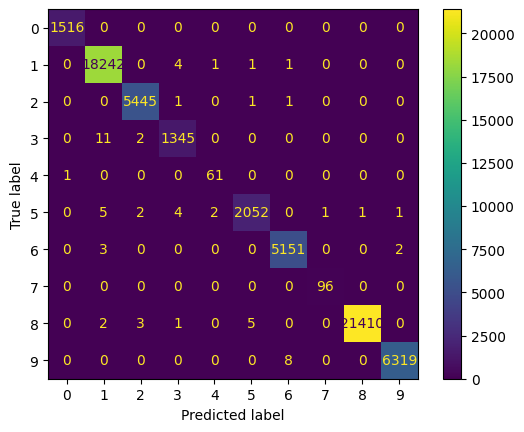

In [21]:
cm = confusion_matrix(y_test, best_clf.predict(X_test), labels=best_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
disp.plot()

---

In [23]:
# Use a split of dataset in order to prevent overfitting

df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

y = df["type"]
df = df.drop(columns=["type"])

oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

# final test split
indeces = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(indeces, test_size=0.1, stratify=y, random_state=seed)
X_test = X[test_idx,:]
y_test = y[test_idx]
X = X[train_idx,:]
y = y[train_idx]

indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
X = lda.transform(X)

X_test = lda.transform(X_test)

print(X_train.shape)
print(X_val.shape)
print(X.shape)
print(X_test.shape)


# SVC
param_grid = {
    'C': [1, 10, 100, 1000], 
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']  
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(SVC(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)
best_clf = grid.best_estimator_


cm = confusion_matrix(y_test, best_clf.predict(X_test), labels=best_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
disp.plot()

(444240, 44)
(111061, 44)
(61701, 44)
(444240, 44)
(111061, 44)
(555301, 9)
(61701, 9)
Fitting 1 folds for each of 24 candidates, totalling 24 fits
[CV 1/1; 1/24] START C=1, gamma=scale, kernel=linear............................[CV 1/1; 3/24] START C=1, gamma=scale, kernel=poly..............................

[CV 1/1; 4/24] START C=1, gamma=auto, kernel=linear.............................
[CV 1/1; 5/24] START C=1, gamma=auto, kernel=rbf................................
[CV 1/1; 6/24] START C=1, gamma=auto, kernel=poly...............................
[CV 1/1; 2/24] START C=1, gamma=scale, kernel=rbf...............................
[CV 1/1; 7/24] START C=10, gamma=scale, kernel=linear...........................
[CV 1/1; 8/24] START C=10, gamma=scale, kernel=rbf..............................
[CV 1/1; 8/24] END C=10, gamma=scale, kernel=rbf; balanced_accuracy: (test=0.977) f1_weighted: (test=0.998) total time= 5.8min
[CV 1/1; 9/24] START C=10, gamma=scale, kernel=poly..........................

/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/1; 23/24] START C=1000, gamma=auto, kernel=rbf............................
[CV 1/1; 23/24] END C=1000, gamma=auto, kernel=rbf; balanced_accuracy: (test=0.993) f1_weighted: (test=0.999) total time= 2.6min
[CV 1/1; 24/24] START C=1000, gamma=auto, kernel=poly...........................
[CV 1/1; 21/24] END C=1000, gamma=scale, kernel=poly; balanced_accuracy: (test=0.987) f1_weighted: (test=0.998) total time=81.8min


KeyboardInterrupt: 

(444240, 44)
(111061, 44)
(61701, 44)
(444240, 44)
(111061, 44)
(555301, 9)
(61701, 9)
Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1; 2/6] START C=100, gamma=auto, kernel=rbf...............................
[CV 1/1; 1/6] START C=100, gamma=scale, kernel=rbf..............................
[CV 1/1; 3/6] START C=1000, gamma=scale, kernel=rbf.............................
[CV 1/1; 5/6] START C=2000, gamma=scale, kernel=rbf.............................
[CV 1/1; 6/6] START C=2000, gamma=auto, kernel=rbf..............................
[CV 1/1; 4/6] START C=1000, gamma=auto, kernel=rbf..............................
[CV 1/1; 5/6] END C=2000, gamma=scale, kernel=rbf; balanced_accuracy: (test=0.994) f1_weighted: (test=0.999) total time= 2.3min
[CV 1/1; 3/6] END C=1000, gamma=scale, kernel=rbf; balanced_accuracy: (test=0.995) f1_weighted: (test=0.999) total time= 2.3min
[CV 1/1; 6/6] END C=2000, gamma=auto, kernel=rbf; balanced_accuracy: (test=0.993) f1_weighted: (test=0.999) tota

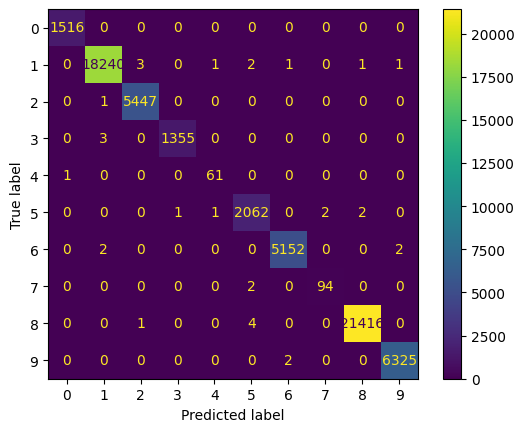

In [7]:
# Use a split of dataset in order to prevent overfitting

df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

y = df["type"]
df = df.drop(columns=["type"])

oe = preprocessing.OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

# final test split
indeces = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(indeces, test_size=0.1, stratify=y, random_state=seed)
X_test = X[test_idx,:]
y_test = y[test_idx]
X = X[train_idx,:]
y = y[train_idx]

indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
# val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
# fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

# X_test = X[test_idx,:]
# y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
X = lda.transform(X)

X_test = lda.transform(X_test)

print(X_train.shape)
print(X_val.shape)
print(X.shape)
print(X_test.shape)


# SVC
param_grid = {
    'C': [100, 1000, 2000], 
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']  
}

scoring = ['balanced_accuracy', 'f1_weighted']

grid = GridSearchCV(SVC(), param_grid, cv=ps, scoring=scoring, n_jobs=-1, verbose=10, refit='balanced_accuracy')
grid.fit(X, y)
print("---------------------------------")
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)
best_clf = grid.best_estimator_


cm = confusion_matrix(y_test, best_clf.predict(X_test), labels=best_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
disp.plot()